### ML-100k

In [ ]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

### ML-1M

In [ ]:
!wget "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
!unzip ml-1m.zip
!ls

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
movies = pd.read_csv('ml-1m/ml-1m/movies.dat',sep = '::' , header=None , engine='python', encoding='latin-1')
ratings = pd.read_csv('ml-1m/ml-1m/ratings.dat' , sep='::' , header=None , engine='python' , encoding='latin-1')
users = pd.read_csv('ml-1m/ml-1m/users.dat' , sep='::' , header=None , engine='python' , encoding='latin-1')

In [4]:
training_set = pd.read_csv('ml-100k/ml-100k/u1.base' , delimiter='\t')
training_set = np.array(training_set,dtype='int')
test_set = pd.read_csv('ml-100k/ml-100k/u1.test' , delimiter='\t')
test_set = np.array(test_set,dtype='int')
len(test_set)

19999

In [5]:
nb_users = int(max(max(training_set[:,0]) , max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]) , max(test_set[:,1])))
nb_movies

1682

In [6]:
def data_convert( data ):
    new_data = []
    for id_users in range(1,nb_users+1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_rating = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies-1] = id_rating
        new_data.append(list(ratings))
    return new_data
training_set = data_convert(training_set)
test_set = data_convert(test_set)

In [7]:
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)
training_set

tensor([[0., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])

In [8]:
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

In [19]:
epochs = 100
training_loss = []
# test_loss = []
epoc = []
for epoch in range(epochs):
    train_loss = 0
    s=0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)
        # target = Variable(test_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data >0) >0 :
            output = sae(input)
            target.requires_grad = False
            output[target==0] = 0
            loss = criterion(output , target)
            mean_corrector = nb_movies/float(torch.sum(target.data >0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data*mean_corrector)
            training_loss.append(train_loss)
            epoc.append(epoch)
            s += 1.
            optimizer.step()
    print('test loss: '+str(train_loss/s))


test loss: tensor(0.9901)
test loss: tensor(0.9888)
test loss: tensor(0.9868)
test loss: tensor(0.9842)
test loss: tensor(0.9836)
test loss: tensor(0.9793)
test loss: tensor(0.9785)
test loss: tensor(0.9749)
test loss: tensor(0.9754)
test loss: tensor(0.9743)
test loss: tensor(0.9725)
test loss: tensor(0.9685)
test loss: tensor(0.9675)
test loss: tensor(0.9671)
test loss: tensor(0.9649)
test loss: tensor(0.9654)
test loss: tensor(0.9638)
test loss: tensor(0.9611)
test loss: tensor(0.9601)
test loss: tensor(0.9615)
test loss: tensor(0.9564)
test loss: tensor(0.9551)
test loss: tensor(0.9559)
test loss: tensor(0.9533)
test loss: tensor(0.9540)
test loss: tensor(0.9515)
test loss: tensor(0.9532)
test loss: tensor(0.9484)
test loss: tensor(0.9510)
test loss: tensor(0.9477)
test loss: tensor(0.9477)
test loss: tensor(0.9455)
test loss: tensor(0.9458)
test loss: tensor(0.9431)
test loss: tensor(0.9449)
test loss: tensor(0.9416)
test loss: tensor(0.9431)
test loss: tensor(0.9410)
test loss: t

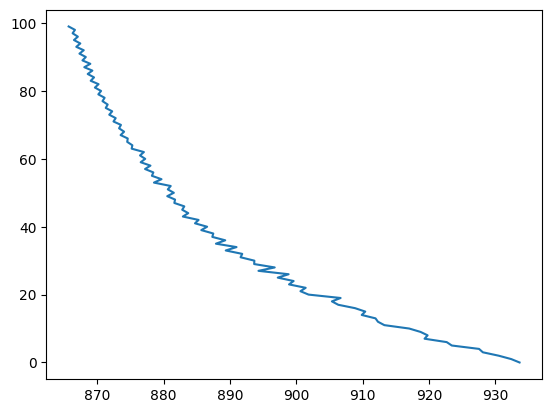

In [20]:
plt.plot(training_loss , epoc)

In [ ]:
epochs = 200
train_loss1 = []
test_lossl = []
epoc = []
for epoch in range(epochs):
    training_loss = 0
    sae.train()
    y_pred = sae(training_set)

    loss = criterion(y_pred , training_set)
    train_loss1.append(loss)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    sae.eval()

    

    with torch.inference_mode():
        
        y_test_pred= sae(test_set)

        test_loss = criterion(y_test_pred,
                        test_set)
        # test_acc = accuracy(y_true=y_test,
        #                 y_pred = test_pred)
        # test_acc_list.append(test_acc)
        epoc.append(epoch)
        test_lossl.append(test_loss)


    # if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.68766 | Test Loss: 0.17393
Epoch: 1 | Loss: 0.68884 | Test Loss: 0.17367
Epoch: 2 | Loss: 0.68763 | Test Loss: 0.17394
Epoch: 3 | Loss: 0.68889 | Test Loss: 0.17366
Epoch: 4 | Loss: 0.68758 | Test Loss: 0.17397
Epoch: 5 | Loss: 0.68897 | Test Loss: 0.17365
Epoch: 6 | Loss: 0.68749 | Test Loss: 0.17400
Epoch: 7 | Loss: 0.68910 | Test Loss: 0.17363
Epoch: 8 | Loss: 0.68736 | Test Loss: 0.17406
Epoch: 9 | Loss: 0.68929 | Test Loss: 0.17360
Epoch: 10 | Loss: 0.68717 | Test Loss: 0.17414
Epoch: 11 | Loss: 0.68956 | Test Loss: 0.17355
Epoch: 12 | Loss: 0.68691 | Test Loss: 0.17425
Epoch: 13 | Loss: 0.68993 | Test Loss: 0.17350
Epoch: 14 | Loss: 0.68655 | Test Loss: 0.17440
Epoch: 15 | Loss: 0.69045 | Test Loss: 0.17342
Epoch: 16 | Loss: 0.68606 | Test Loss: 0.17461
Epoch: 17 | Loss: 0.69115 | Test Loss: 0.17335
Epoch: 18 | Loss: 0.68543 | Test Loss: 0.17491
Epoch: 19 | Loss: 0.69208 | Test Loss: 0.17329
Epoch: 20 | Loss: 0.68469 | Test Loss: 0.17532
Epoch: 21 | Loss: 0.693

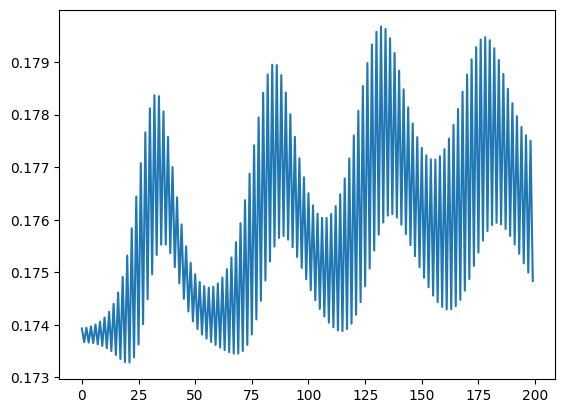

In [ ]:
plt.plot(epoc,test_lossl)